In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
import logging
import talib
import yfinance as yf
import tqdm
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from lag_llama.gluon.estimator import LagLlamaEstimator
from transformers import AdamW, get_scheduler
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
print(f"Using device: {device}")  # Optional: to confirm the device being used

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Fetch SPY data
logging.info("Fetching stock data...")
stock_data = yf.download('SPY', start='2004-01-01', end='2024-05-17')

# Swap "Adj Close" data into the "Close" column
logging.info("Swapping 'Adj Close' data into 'Close' column...")
stock_data['Close'] = stock_data['Adj Close']

# Remove the "Adj Close" column
logging.info("Removing 'Adj Close' column...")
stock_data = stock_data.drop(columns=['Adj Close'])

# Checking for missing values
logging.info("Checking for missing values...")
logging.info(stock_data.isnull().sum())

# Filling missing values, if any
logging.info("Filling missing values, if any...")
stock_data.ffill(inplace=True)
stock_data.dropna(inplace=True)

logging.info("Calculating technical indicators...")
stock_data['SMA_10'] = talib.SMA(stock_data['Close'], timeperiod=10)
stock_data['SMA_50'] = talib.SMA(stock_data['Close'], timeperiod=50)
stock_data['EMA_20'] = talib.EMA(stock_data['Close'], timeperiod=20)
stock_data['RSI'] = talib.RSI(stock_data['Close'], timeperiod=14)
stock_data['STOCH_K'], stock_data['STOCH_D'] = talib.STOCH(stock_data['High'], stock_data['Low'], stock_data['Close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
stock_data['MACD'], stock_data['MACDSIGNAL'], stock_data['MACDHIST'] = talib.MACD(stock_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['ADX'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['OBV'] = talib.OBV(stock_data['Close'], stock_data['Volume'])
stock_data['ATR'] = talib.ATR(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['BBANDS_UPPER'], stock_data['BBANDS_MIDDLE'], stock_data['BBANDS_LOWER'] = talib.BBANDS(stock_data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
stock_data['MOM'] = talib.MOM(stock_data['Close'], timeperiod=10)
stock_data['CCI'] = talib.CCI(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['WILLR'] = talib.WILLR(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['TSF'] = talib.TSF(stock_data['Close'], timeperiod=14)
stock_data['TRIX'] = talib.TRIX(stock_data['Close'], timeperiod=30)
stock_data['ULTOSC'] = talib.ULTOSC(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
stock_data['ROC'] = talib.ROC(stock_data['Close'], timeperiod=10)
stock_data['PLUS_DI'] = talib.PLUS_DI(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['MINUS_DI'] = talib.MINUS_DI(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['PLUS_DM'] = talib.PLUS_DM(stock_data['High'], stock_data['Low'], timeperiod=14)
stock_data['MINUS_DM'] = talib.MINUS_DM(stock_data['High'], stock_data['Low'], timeperiod=14)

logging.info("Checking for NaN values after calculating technical indicators...")
logging.info(stock_data.isnull().sum())

data_close = stock_data['Close'].values.reshape(-1, 1)
split = int(len(data_close) * 0.9)
data_close_train, data_close_test = data_close[:split], data_close[split:]

# Normalize the Close prices
scaler = MinMaxScaler(feature_range=(-1, 1))
price_data_train = scaler.fit_transform(data_close_train).flatten()
price_data_test = scaler.transform(data_close_test).flatten()

# Variable to control the number of future steps to predict
steps = 10

# Data Preprocessing Function modified for multi-step
def create_sequences(data, sequence_length, steps):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - steps + 1):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length:i + sequence_length + steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences with modified function
sequence_length = 64

# Split the data
X_train, y_train = create_sequences(price_data_train, sequence_length, steps)
X_test, y_test = create_sequences(price_data_test, sequence_length, steps)

# Convert to PyTorch tensors, adjusted for multi-step
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader instances, adjusted for multi-step
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

[*********************100%%**********************]  1 of 1 completed

Using device: cuda


In [17]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm.tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm.tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\gluonts\dataset\split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\gluonts\transform\feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\gluonts\transform\feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index = pd.period_range(start, periods=length, freq=start.freq)
c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\gluonts\transform\split.py:150: FutureWarning: Period with BDay freq is deprecated and will b

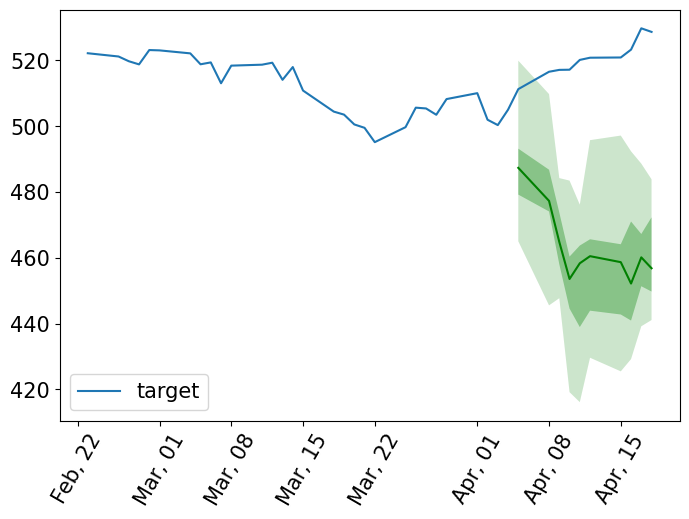

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\gluonts\transform\feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instea

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 5.03455 (best 5.03455), saving model to 'c:\\Users\\becke\\Projects\\NBBot\\lagllama\\lightning_logs\\version_18\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.15444 (best 4.15444), saving model to 'c:\\Users\\becke\\Projects\\NBBot\\lagllama\\lightning_logs\\version_18\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 3.42090 (best 3.42090), saving model to 'c:\\Users\\becke\\Projects\\NBBot\\lagllama\\lightning_logs\\version_18\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 3.00765 (best 3.00765), saving model to 'c:\\Users\\becke\\Projects\\NBBot\\lagllama\\lightning_logs\\version_18\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 2.88214 (best 2.882

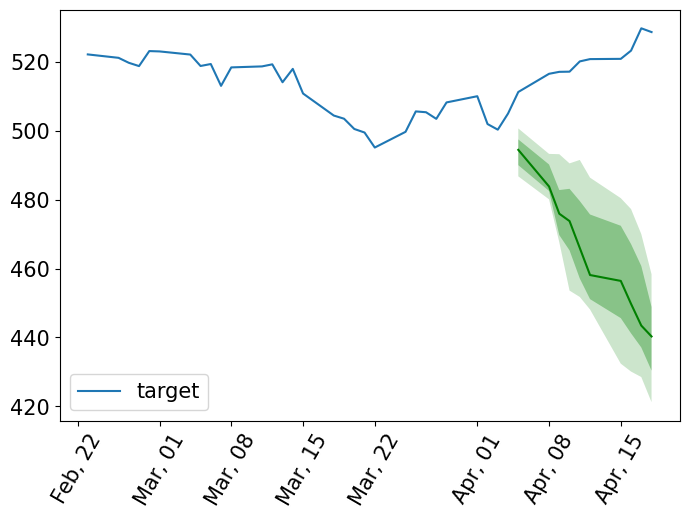

c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\gluonts\evaluation\_base.py:365: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  date_before_forecast = forecast.index[0] - forecast.freq
Running evaluation: 1it [00:00, ?it/s]
c:\Users\becke\miniconda3\envs\pt-gpu-v2\lib\site-packages\gluonts\evaluation\_base.py:289: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  metrics_per_ts = pd.DataFrame.from_records(rows)


Aggregate metrics: {'MSE': 3475.0140625, 'abs_error': 563.728759765625, 'abs_target_sum': 5205.88037109375, 'abs_target_mean': 520.588037109375, 'seasonal_error': 7.525388664031125, 'MASE': 7.491025180666913, 'MAPE': 0.10787581205368042, 'sMAPE': 0.1150280475616455, 'MSIS': 166.69339926365186, 'num_masked_target_values': 0.0, 'QuantileLoss[0.1]': 138.952880859375, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.2]': 259.1538452148438, 'Coverage[0.2]': 0.0, 'QuantileLoss[0.3]': 375.60778198242184, 'Coverage[0.3]': 0.0, 'QuantileLoss[0.4]': 483.28378906250003, 'Coverage[0.4]': 0.0, 'QuantileLoss[0.5]': 563.7287292480469, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.6]': 621.7708007812499, 'Coverage[0.6]': 0.0, 'QuantileLoss[0.7]': 665.343505859375, 'Coverage[0.7]': 0.0, 'QuantileLoss[0.8]': 700.927783203125, 'Coverage[0.8]': 0.0, 'QuantileLoss[0.9]': 704.1154724121093, 'Coverage[0.9]': 0.0, 'RMSE': 58.94924988920555, 'NRMSE': 0.11323589035300934, 'ND': 0.10828692163112195, 'wQuantileLoss[0.1]': 0.0266915

In [21]:
def fine_tune_lag_llama(train_dataset, test_dataset, prediction_length, context_length=32, num_samples=20, batch_size=64, max_epochs=50, lr=5e-4, device="cuda"):
    # Load the checkpoint
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    # Create the estimator
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=lr,
        # Estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        batch_size=int(batch_size),  # Ensure batch_size is an integer
        num_parallel_samples=num_samples,
        trainer_kwargs={"max_epochs": max_epochs, "accelerator": device},
    )

    # Train the estimator
    predictor = estimator.train(train_dataset, cache_data=True, shuffle_buffer_length=1000)

    # Generate predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

    # Convert iterators to lists
    forecasts = list(tqdm.tqdm(forecast_it, total=len(test_dataset), desc="Forecasting batches"))
    tss = list(tqdm.tqdm(ts_it, total=len(test_dataset), desc="Ground truth"))

    return forecasts, tss

# Preparing dataset and parameters
start_date_train = pd.to_datetime(stock_data.index[0])
start_date_test = pd.to_datetime(stock_data.index[split])

# Prepare dataset for Lag-Llama
train_gluon_ds = ListDataset([{"start": start_date_train, "target": data_close_train[:, 0]}], freq="B")
test_gluon_ds = ListDataset([{"start": start_date_test, "target": data_close_test[:, 0]}], freq="B")

# Zero Shot Prediction
prediction_length = steps
context_length = prediction_length * 3
num_samples = 20

# Generate initial predictions
forecasts, tss = get_lag_llama_predictions(
    test_gluon_ds,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
)

# Plot initial predictions
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Fine-tuning
prediction_length = steps
context_length = prediction_length * 3
num_samples = 20

# Fine-tune and generate predictions
forecasts, tss = fine_tune_lag_llama(train_gluon_ds, test_gluon_ds, prediction_length, context_length, num_samples, device="cuda")

# Plot fine-tuned predictions
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Evaluate the forecasts
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print(f'Aggregate metrics: {agg_metrics}')

In [22]:
class LagLlamaModel(nn.Module):
    def __init__(self, input_size, context_length, prediction_length):
        super(LagLlamaModel, self).__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.device = device

        ckpt = torch.load("lag-llama.ckpt", map_location=device)
        estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

        self.estimator = LagLlamaEstimator(
            ckpt_path="lag-llama.ckpt",
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            input_size=estimator_args["input_size"],
            n_layer=estimator_args["n_layer"],
            n_embd_per_head=estimator_args["n_embd_per_head"],
            n_head=estimator_args["n_head"],
            scaling=estimator_args["scaling"],
            time_feat=estimator_args["time_feat"],
            nonnegative_pred_samples=True,
            rope_scaling={
                "type": "linear",
                "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
            },
            batch_size=64,
            num_parallel_samples=20,
        )

        self.lightning_module = self.estimator.create_lightning_module()
        self.transformation = self.estimator.create_transformation()
        self.predictor = self.estimator.create_predictor(self.transformation, self.lightning_module)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        return self.predictor(x)

# Initialize and evaluate the model
input_size = len(['Close', 'SMA_10', 'SMA_50', 'EMA_20', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACDSIGNAL', 'MACDHIST', 'ADX', 
                  'OBV', 'ATR', 'BBANDS_UPPER', 'BBANDS_MIDDLE', 'BBANDS_LOWER', 'MOM', 'CCI', 'WILLR', 'TSF', 'TRIX', 
                  'ULTOSC', 'ROC', 'PLUS_DI', 'MINUS_DI', 'PLUS_DM', 'MINUS_DM'])

model = LagLlamaModel(input_size=input_size, context_length=sequence_length, prediction_length=steps).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

In [25]:
def train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs, patience, monitor='val_loss'):
    logging.info("Starting training...")
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    scaler = GradScaler()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            
            with autocast():
                predictions = model(sequences)
                loss = criterion(predictions, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            total_loss += loss.item()
        
        validation_loss = evaluate(model, test_loader, criterion)
        logging.info(f'Epoch {epoch+1}: Training Loss: {total_loss/len(train_loader)}, Validation Loss: {validation_loss}')
        
        early_stopping(validation_loss, model)
        if early_stopping.early_stop:
            logging.info("Early stopping")
            break
    
    torch.save(model.state_dict(), 'checkpoint.pt')
    model.load_state_dict(torch.load('checkpoint.pt', map_location=device))

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            predictions = model(sequences)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Assume the following variables are defined: model, train_loader, test_loader, optimizer, criterion, scheduler, device
train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs=50, patience=5, monitor='val_loss')

model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    for batch in test_loader:
        sequences, labels = batch
        sequences, labels = sequences.to(device), labels.to(device)
        preds = model(sequences)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions).reshape(-1, steps)
true_labels = np.array(true_labels).reshape(-1, steps)

mae = mean_absolute_error(true_labels, predictions, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(true_labels, predictions, multioutput='raw_values'))
print(f'MAE: {np.mean(mae)}')
print(f'RMSE: {np.mean(rmse)}')

# Plot actual vs predicted prices
time_steps = np.arange(len(true_labels))

plt.figure(figsize=((8,7)))
plt.plot(time_steps, true_labels, label='Actual Prices', color='blue', linewidth=2)
plt.plot(time_steps, predictions, label='Predicted Prices', color='red', linewidth=2)
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: EarlyStopping.__init__() missing 1 required positional argument: 'monitor'